### Packages

In [15]:
###Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import pickle

## Data Import

In [2]:
df = pd.read_csv("DataTrain-2.csv")

#### Check for null values and infinite values

In [3]:
# Checking which columns have any null values
columns_with_nulls = df.isnull().any()

# Filtering to show only columns with null values
columns_with_nulls_true = columns_with_nulls[columns_with_nulls].index.tolist()

print("Columns with null values:", columns_with_nulls_true)

# Check for columns with infinite values (positive or negative)
infinite_columns = df.isin([np.inf, -np.inf]).any()

# Filter and print column names that have infinite values
columns_with_infinity = infinite_columns[infinite_columns].index.tolist()
print("Columns with infinite values:", columns_with_infinity)

Columns with null values: []
Columns with infinite values: []


#### Create a new column RUL 

In [4]:
# Creating a new column with the max 'cycle' per 'engine_id'
df['max_cycle_per_engine'] = df.groupby('engine_id')['cycle'].transform('max')
# Creating the 'cycles_left' column
df['RUL'] = df['max_cycle_per_engine'] - df['cycle']
df.drop(['max_cycle_per_engine'], axis=1, inplace=True)

### Remove features with zero variance

In [5]:
# Calculating variance for each column
variances = df.var()

# Identifying columns with zero variance
zero_variance_columns = variances[variances == 0].index.tolist()

print("Columns with zero variance:", zero_variance_columns)

# Filtering out columns with zero variance
df = df.loc[:, variances > 0]

Columns with zero variance: ['set1', 'sensor_val7', 'sensor_val11', 'sensor_val14', 'sensor_val16']


#### Remove the columns with one unique value

In [6]:
# Checking the number of unique values per column
unique_counts = df.nunique()

# Identifying columns with only one unique value
columns_to_remove = unique_counts[unique_counts == 1].index.tolist()

# Removing these columns from the DataFrame
df.drop(columns=columns_to_remove, inplace=True)

# Printing the names of the columns that were removed
print("Columns removed:", columns_to_remove)

Columns removed: ['sensor_val8', 'sensor_val20']


              engine_id     cycle      set2      set3  sensor_val1  \
engine_id      1.000000  0.078753 -0.017895 -0.006197    -0.052053   
cycle          0.078753  1.000000 -0.004527  0.016132     0.443999   
set2          -0.017895 -0.004527  1.000000  0.011660    -0.004279   
set3          -0.006197  0.016132  0.011660  1.000000    -0.005425   
sensor_val1   -0.052053  0.443999 -0.004279 -0.005425     1.000000   
sensor_val2   -0.031882 -0.611354 -0.001491 -0.010923    -0.210238   
sensor_val3   -0.059473  0.370324 -0.004469 -0.006310     0.963157   
sensor_val4    0.012621  0.543947 -0.005651  0.009068     0.322964   
sensor_val5   -0.032073 -0.595914 -0.009437 -0.016678    -0.217835   
sensor_val6   -0.020589 -0.583597 -0.005713 -0.010554    -0.285280   
sensor_val9    0.044230  0.477523  0.002318  0.018156    -0.034763   
sensor_val10   0.026116  0.624577  0.009544  0.014673     0.297429   
sensor_val12   0.013513  0.566995  0.002599  0.012280     0.337110   
sensor_val13   0.039

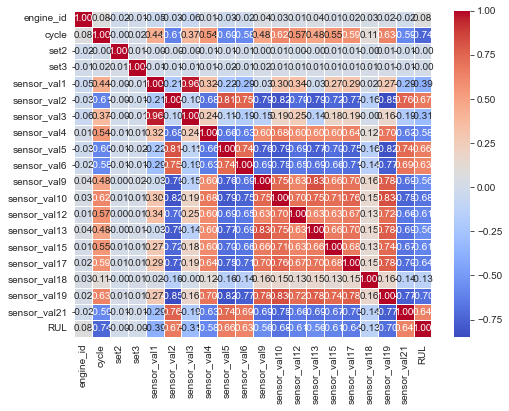

In [7]:
# Calculating the correlation matrix
correlation_matrix = df.corr()

# Display the correlation matrix
print(correlation_matrix)

# Visualizing the correlation matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.show()

In [8]:
rul_correlations = correlation_matrix['RUL']

# Display the correlations of 'RUL' with other features
print(rul_correlations)

engine_id       0.078753
cycle          -0.736241
set2           -0.003198
set3           -0.001948
sensor_val1    -0.390102
sensor_val2     0.671983
sensor_val3    -0.306769
sensor_val4    -0.584520
sensor_val5     0.657223
sensor_val6     0.629428
sensor_val9    -0.562569
sensor_val10   -0.678948
sensor_val12   -0.606154
sensor_val13   -0.563968
sensor_val15   -0.606484
sensor_val17   -0.642667
sensor_val18   -0.128348
sensor_val19   -0.696228
sensor_val21    0.635662
RUL             1.000000
Name: RUL, dtype: float64


In [9]:
df.columns

Index(['engine_id', 'cycle', 'set2', 'set3', 'sensor_val1', 'sensor_val2',
       'sensor_val3', 'sensor_val4', 'sensor_val5', 'sensor_val6',
       'sensor_val9', 'sensor_val10', 'sensor_val12', 'sensor_val13',
       'sensor_val15', 'sensor_val17', 'sensor_val18', 'sensor_val19',
       'sensor_val21', 'RUL'],
      dtype='object')

In [10]:
# Defining the dependent variable and independent variables
X = df[['cycle', 'set2', 'set3', 'sensor_val1', 'sensor_val2',
       'sensor_val3', 'sensor_val4', 'sensor_val5', 'sensor_val6',
       'sensor_val9', 'sensor_val10', 'sensor_val12', 'sensor_val13',
       'sensor_val15', 'sensor_val17', 'sensor_val18', 'sensor_val19',
       'sensor_val21']]
y = df['RUL']

# Adding a constant to the model (intercept)
X = sm.add_constant(X)

# Setting up the OLS model
model = sm.OLS(y, X)

# Fitting the model
results = model.fit()

# Printing the summary of the model
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    RUL   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     2180.
Date:                Thu, 25 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:52:11   Log-Likelihood:            -1.0560e+05
No. Observations:               20631   AIC:                         2.112e+05
Df Residuals:                   20612   BIC:                         2.114e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.259e+05   2.59e+04      4.853   

eventhough set 2 had a higher correlation with RUL than set 3, controlling for other variables revealed that set 2 is not significant

remove set 2 as a feature

In [11]:
df.drop(["engine_id","set2"], axis=1, inplace=True)

In [12]:
# Define the dependent variable and independent variables
X = df.drop('RUL', axis=1)
y = df['RUL']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Creating the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fitting the model
rf_model.fit(X_train, y_train)

# Applying 5-fold cross-validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring=make_scorer(mean_absolute_error))

# Output the results of cross-validation
print("CV Scores:", cv_scores)
print("CV Average Score:", np.mean(cv_scores))

CV Scores: [24.90042411 25.8700515  25.47068767 25.46362617 25.63502727]
CV Average Score: 25.467963346093466


In [13]:
# Random Forest model setup
rf = RandomForestRegressor(random_state=42)

# Define parameter space for Bayesian Optimization
search_spaces = {
    'n_estimators': Integer(50, 200),
    'max_depth': Integer(10, 30),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 4)
}

# Setting up Bayesian Search
opt = BayesSearchCV(estimator=rf, search_spaces=search_spaces, n_iter=32, scoring='neg_mean_absolute_error', n_jobs=-1, cv=5, verbose=2, random_state=42)

# Fitting Bayesian Search
opt.fit(X_train, y_train)

# Best model evaluation
print("Best parameters:", opt.best_params_)
print("Best score (neg_mean_absolute_error):", opt.best_score_)

# Optionally, check the performance on the test set
best_rf = opt.best_estimator_
best_rf.fit(X_train, y_train)
test_score = best_rf.score(X_test, y_test)
print("Test set score:", test_score)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [16]:
# Specify the file path to save the model
model_file_path = 'best_random_forest_model.pkl'

# Save the model to disk
with open(model_file_path, 'wb') as file:
    pickle.dump(best_rf, file)

print(f"Model saved to {model_file_path}")

Model saved to best_random_forest_model.pkl


In [ ]:
## try lag feature RUL